In [1]:
%matplotlib inline
import time
from notebook_init import *

out_root = Path('out/1dim')
makedirs(out_root, exist_ok=True)
rand = lambda : np.random.randint(np.iinfo(np.int32).max)
torch.autograd.set_grad_enabled(True)

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [2]:
# BigGAN-512 irish setter
dataset = 'husky'
inst = get_instrumented_model('BigGAN-512', dataset, 'generator.gen_z', device, inst=inst)
model = inst.model
model.set_output_class('irish_setter')
model.truncation = 0.6


In [3]:
''' Seed for BigGAN in GANSpace '''
seeds_ffhq = [489408325]
# semantic : (axis, layer_start, layter_end, pertubation intensity (sigma scaled), inverted)
#     'Move right':       ( 0,  0, 15, -1.5, False),
#     'Rotate':           ( 3,  0, 15,  -0.5, False),
#     'Move back':        ( 4,  0, 15,  2.5, False),
#     'Zoom in':          ( 6,  0, 15, -2.0, False),
#     'Zoom out':         (12,  0, 15, -4.0, False),
#     'Sharpen BG':       (13,  6,  9, 20.0, False),
#     'Camera down':      (15,  1,  6, -4.0, False),
#     'Light right':      (28,  7,  8,  30, False),
#     'Pixelate':         (46, 10, 11,  -25, False),
#     'Reeds':            (61,  4,  8,  -15, False),
#     'Dry BG':           (65,  6,  8,  -30, False),
#     'Grass length':     (69,  5,  8,   15, False),

start_direction = 0
n_direction = 5
num_frames = 7
layer_mode = 'all'
perturb_intensity = 5

## Local Basis

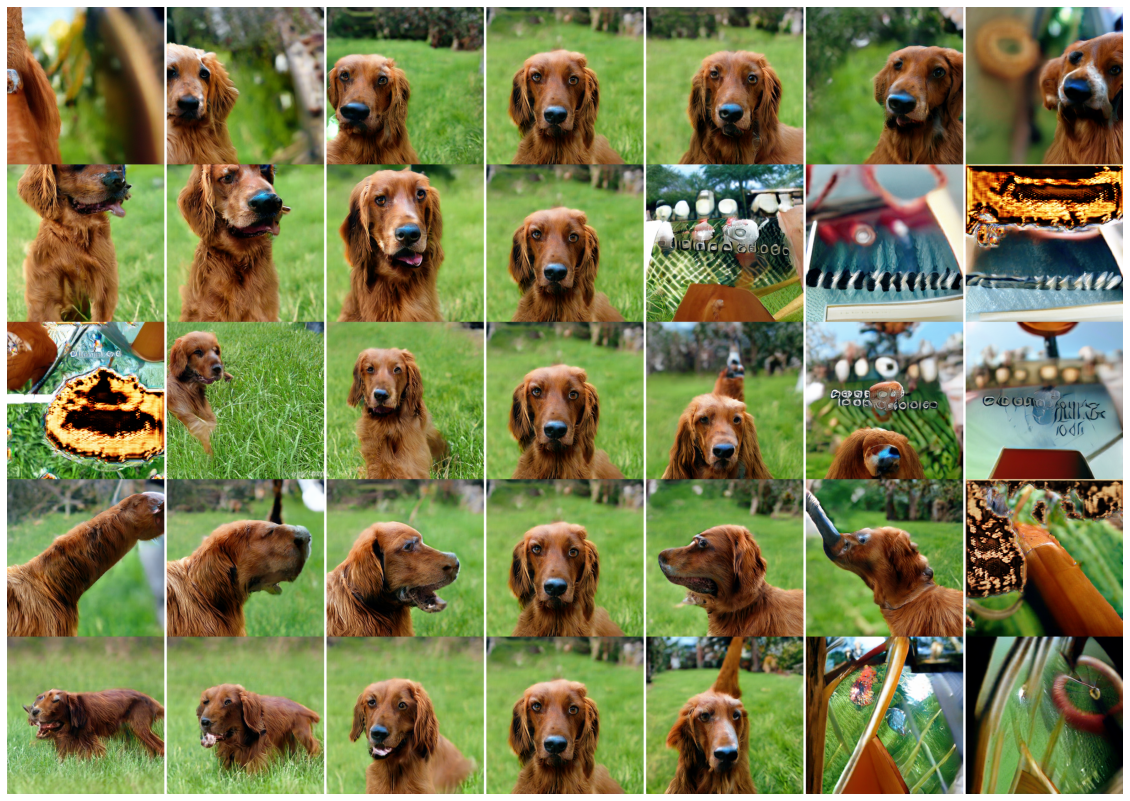

In [4]:
from scipy.stats import truncnorm
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    ''' BigGAN takes truncated normal noise '''
    noise = truncnorm.rvs(-2, 2, size = (1, 128), random_state = rng).astype(np.float32)
    noise = torch.from_numpy(noise).float().to(model.device)
    
    noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng, noise, noise_dim = 128)
    ''' On BigGAN, we should perform traverse on noise because noise is injected to each generator layer '''
    ''' By traversing noise by noise_basis, we can traverse z by z_local_basis simultaneously. '''
    lb_dir = noise_basis.t().unsqueeze(1).detach().to(device) #reshape    
    layer_start, layer_end = 0, inst.model.get_max_latents() ## Traverse all layer     
    
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'generator.gen_z', [noise], 0, lb_dir[i], 0, 1, 0, noise, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'LocalBasis_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

# GANSpace - Only for FFHQ

In [5]:
#gs_dir = np.load('./global_directions/ganspace_directions_ffhq_stylegan2.npy')#Note! Only ffhq is provided.
#gs_dir = np.load('./global_directions/ganspace_directions_ffhq_stylegan.npy')#Note! Only ffhq is provided.
gs_dir = np.load('./global_directions/biggan-512-husky_generator.gen_z_ipca_c80_n1000000.npz')['lat_comp']#Note! Only ffhq is provided.

print(gs_dir.shape)
gs_dir = torch.from_numpy(gs_dir).to(device)

(80, 1, 128)


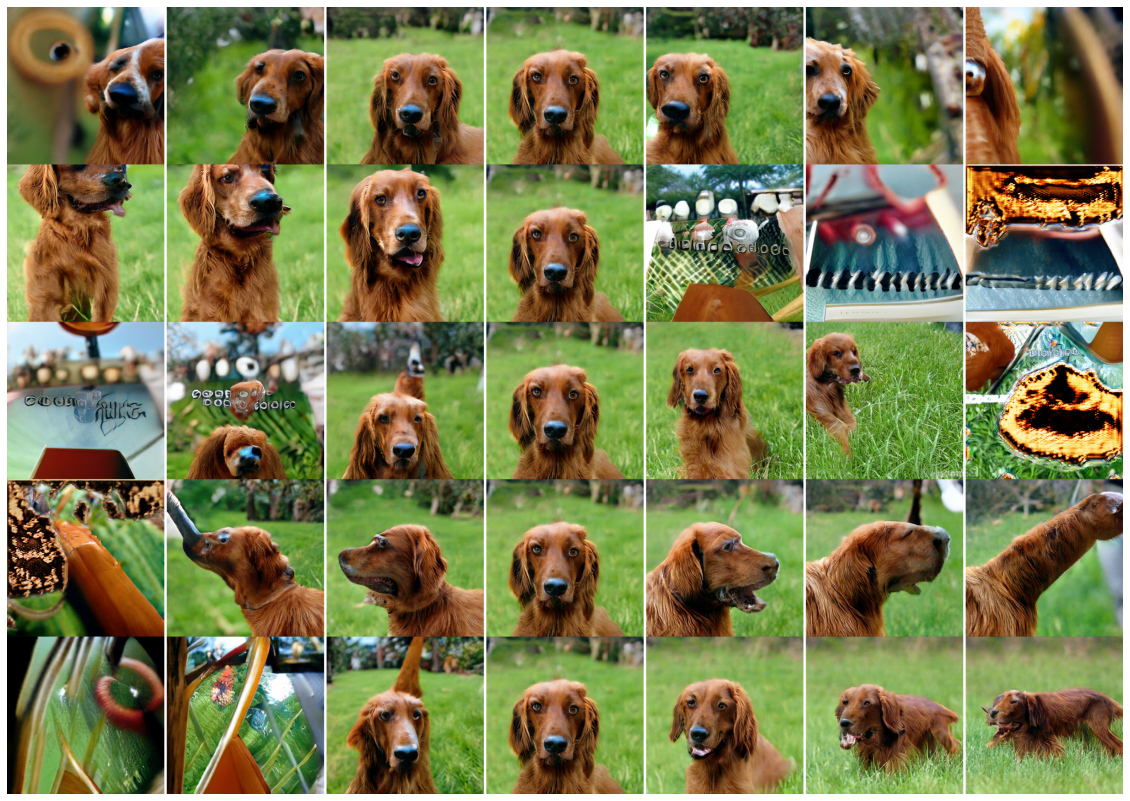

In [6]:
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    ''' BigGAN takes truncated normal noise '''
    noise = truncnorm.rvs(-2, 2, size = (1, 128), random_state = rng).astype(np.float32)
    noise = torch.from_numpy(noise).float().to(model.device)    
    layer_start, layer_end = 0, inst.model.get_max_latents() ## Traverse all layer   
    
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'generator.gen_z', [noise], 0, gs_dir[i], 0, 1, 0, noise, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'ganspace_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

# SeFa - Only for FFHQ

In [ ]:
sf_dir = np.load('./global_directions/sefa_directions_ffhq.npy') #Note! Only ffhq is provided.
sf_dir = torch.from_numpy(sf_dir).to(device)

In [ ]:
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    noise = torch.from_numpy(
            rng.standard_normal(512 * 1)
            .reshape(1, 512)).float().to(model.device) #[N, 512]
    if model.w_primary:
        z = model.model.style(noise)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z], 0, sf_dir[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'sefa_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()